In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
dataset = pd.read_csv("/kaggle/input/datasetv1/merged_fitness_data_fixed.csv")

In [ ]:
dataset.head()

In [ ]:
dataset.info()

In [ ]:
# List of profile columns
profile_cols = ["name", "email", "age", "gender", "height", "fitness_level", "join_date"]

# Create a mapping of user_id → profile info (dropna ensures we only keep filled rows)
profile_info = dataset.dropna(subset=profile_cols).groupby("user_id")[profile_cols].first()

# Map back to main DataFrame
for col in profile_cols:
    dataset[col] = dataset[col].fillna(dataset["user_id"].map(profile_info[col]))

In [ ]:
dataset.info()

In [ ]:
def fill_missing_label_features(df):
    """
    Fill missing values for the features needed to compute labels
    (Energy, Recovery, Readiness) according to the specified rules.
    """

    df = df.copy()

    # Calories → per-user mean, fallback to global mean
    if "calories" in df.columns:
        df["calories"] = df.groupby("user_id")["calories"].transform(lambda x: x.fillna(x.mean()))
        df["calories"].fillna(df["calories"].mean(), inplace=True)

    # Calories burned → 0 if missing
    if "calories_burned" in df.columns:
        df["calories_burned"].fillna(0, inplace=True)

    # Sleep, rest_time, value → per-user mean, fallback to global mean
    for col in ["total_sleep", "deep_sleep", "rest_time", "value"]:
        if col in df.columns:
            df[col] = df.groupby("user_id")[col].transform(lambda x: x.fillna(x.mean()))
            df[col].fillna(df[col].mean(), inplace=True)

    # Intensity → per-user mode, fallback = "Low"
    if "intensity" in df.columns:
        df["intensity"] = df.groupby("user_id")["intensity"].transform(
            lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Low")
        )

    # Resting heart rate → 7-day rolling mean per user, fallback to global mean
    if "resting_heart_rate" in df.columns:
        df["resting_heart_rate"] = df.groupby("user_id")["resting_heart_rate"].transform(
            lambda x: x.fillna(x.rolling(7, min_periods=1).mean())
        )
        df["resting_heart_rate"].fillna(df["resting_heart_rate"].mean(), inplace=True)

    # Nutrition → global average
    for col in ["protein", "carbs", "fat"]:
        if col in df.columns:
            df[col].fillna(df[col].mean(), inplace=True)

    # Keep only necessary columns for labels
    features_needed = [
        "user_id", "date", "calories", "calories_burned",
        "total_sleep", "intensity", "deep_sleep", "value",
        "rest_time", "protein", "carbs", "fat", "resting_heart_rate"
    ]
    return df[features_needed]

In [ ]:
df_filled = fill_missing_label_features(dataset)

In [ ]:
df_filled.info()

In [ ]:
df = df_filled

In [128]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def calculate_fitness_scores(df, window_size=7):
    """
    Calculate scientifically-grounded Energy, Recovery, and Readiness scores
    using a consistent window size for all rolling calculations.
    
    Parameters:
    df: DataFrame with fitness data
    window_size: Rolling window size for all metrics (days)
    
    Returns:
    DataFrame with added score columns
    """
    
    # Make a copy to avoid modifying original data
    df = df.copy()
    
    # Sort by user and date
    df = df.sort_values(['user_id', 'date'])
    
    # 1. ENERGY SCORE CALCULATION
    # Map intensity to numerical values
    intensity_map = {"Low": 0.3, "Moderate": 0.6, "High": 1.0}
    df["ActivityIntensityNum"] = df["intensity"].map(intensity_map).fillna(0.3)
    
    # Calculate net calories
    df["NetCalories"] = df["calories"] - df["calories_burned"]
    
    # Calculate rolling averages for energy components
    df = calculate_energy_metrics(df, window_size)
    
    # Normalize energy components (0-1 range)
    df = normalize_energy_components(df)
    
    # Calculate Energy Score
    df["Energy"] = (0.4 * df["Norm_NetCalories"]) + (0.3 * df["Norm_Sleep"]) + (0.3 * df["Norm_Intensity"])
    
    # 2. RECOVERY SCORE CALCULATION
    df = calculate_recovery_metrics(df, window_size)
    
    # 3. NUTRITION SCORE CALCULATION
    df = calculate_nutrition_score(df, window_size)
    
    # 4. READINESS SCORE CALCULATION
    df["Readiness"] = (0.5 * df["Recovery"]) + (0.3 * df["Energy"]) + (0.2 * df["NutritionScore"])
    
    # Scale all scores to 0-100 range
    df = scale_scores_to_100(df)
    
    return df

def calculate_energy_metrics(df, window_size):
    """Calculate rolling energy metrics"""
    df = df.copy()
    
    # Group by user and calculate rolling means
    def calculate_user_energy(user_df):
        user_df = user_df.copy()
        user_df["NetCaloriesRoll"] = user_df["NetCalories"].rolling(window_size, min_periods=1).mean()
        user_df["SleepRoll"] = user_df["total_sleep"].rolling(window_size, min_periods=1).mean()
        user_df["IntensityRoll"] = user_df["ActivityIntensityNum"].rolling(window_size, min_periods=1).mean()
        return user_df
    
    return df.groupby('user_id').apply(calculate_user_energy).reset_index(drop=True)

def calculate_recovery_metrics(df, window_size):
    """Calculate recovery metrics with consistent window size"""
    df = df.copy()
    
    def calculate_user_recovery(user_df):
        user_df = user_df.copy()
        
        # Calculate deep sleep ratio
        user_df["DeepSleepRatio"] = user_df["deep_sleep"] / user_df["total_sleep"].replace(0, np.nan)
        user_df["DeepSleepRatio"].fillna(0, inplace=True)
        
        # Calculate rolling averages for recovery components
        user_df["DeepSleepRoll"] = user_df["DeepSleepRatio"].rolling(window_size, min_periods=1).mean()
        user_df["RHRRoll"] = user_df["resting_heart_rate"].rolling(window_size, min_periods=1).mean()
        
        # For HRV, use rolling average instead of complex baseline calculation
        if "value" in user_df.columns:
            user_df["HRVRoll"] = user_df["value"].rolling(window_size, min_periods=1).mean()
        else:
            user_df["HRVRoll"] = np.nan
        
        return user_df
    
    df = df.groupby('user_id').apply(calculate_user_recovery).reset_index(drop=True)
    
    # Normalize recovery components (simplified approach)
    df["Norm_DeepSleep"] = np.clip(df["DeepSleepRoll"] / 0.25, 0, 1)  # Target: 25% deep sleep
    df["Norm_RHR"] = np.clip(1 - (df["RHRRoll"] - 50) / 50, 0, 1)  # Lower RHR is better
    
    if "HRVRoll" in df.columns:
        df["Norm_HRV"] = np.clip((df["HRVRoll"] - 30) / 50, 0, 1)  # Higher HRV is better
    else:
        df["Norm_HRV"] = 0.5  # Default value if HRV data missing
    
    # Calculate Recovery Score
    df["Recovery"] = (0.4 * df["Norm_HRV"]) + (0.3 * df["Norm_DeepSleep"]) + (0.3 * df["Norm_RHR"])
    
    return df

def calculate_nutrition_score(df, window_size):
    """Calculate nutrition score with rolling average"""
    df = df.copy()
    
    def calculate_user_nutrition(user_df):
        user_df = user_df.copy()
        
        # Calculate daily nutrition metrics
        user_df["ProteinSufficiency"] = np.clip(user_df["protein"] / 100, 0, 1.5)  # Simplified protein target
        
        # Macronutrient balance
        user_df["calories_macros"] = 4 * user_df["protein"] + 4 * user_df["carbs"] + 9 * user_df["fat"]
        
        # Handle division by zero
        user_df["carbs_pct"] = np.where(user_df["calories_macros"] > 0, 
                                       user_df["carbs"] * 4 / user_df["calories_macros"], 0)
        user_df["protein_pct"] = np.where(user_df["calories_macros"] > 0, 
                                         user_df["protein"] * 4 / user_df["calories_macros"], 0)
        user_df["fat_pct"] = np.where(user_df["calories_macros"] > 0, 
                                     user_df["fat"] * 9 / user_df["calories_macros"], 0)
        
        # Macronutrient balance score
        user_df["MacroBalance"] = 1 - ((abs(user_df["carbs_pct"] - 0.5) + 
                                      abs(user_df["protein_pct"] - 0.25) + 
                                      abs(user_df["fat_pct"] - 0.25)) / 3)
        
        # Calculate rolling averages
        user_df["ProteinRoll"] = user_df["ProteinSufficiency"].rolling(window_size, min_periods=1).mean()
        user_df["MacroBalanceRoll"] = user_df["MacroBalance"].rolling(window_size, min_periods=1).mean()
        
        return user_df
    
    df = df.groupby('user_id').apply(calculate_user_nutrition).reset_index(drop=True)
    
    # Calculate Nutrition Score
    df["NutritionScore"] = (0.6 * df["ProteinRoll"]) + (0.4 * df["MacroBalanceRoll"])
    
    return df

def normalize_energy_components(df):
    """Normalize energy components to 0-1 range"""
    # Normalize net calories (target range: -500 to +500 kcal)
    df["Norm_NetCalories"] = np.clip((df["NetCaloriesRoll"] + 500) / 1000, 0, 1)
    
    # Normalize sleep (target range: 6-9 hours)
    df["Norm_Sleep"] = np.clip((df["SleepRoll"] - 6) / 3, 0, 1)
    
    # Intensity is already 0-1
    df["Norm_Intensity"] = df["IntensityRoll"]
    
    return df

def scale_scores_to_100(df):
    """Scale all scores to 0-100 range while preserving meaningful scale"""
    for score in ["Energy", "Recovery", "NutritionScore", "Readiness"]:
        if score in df.columns:
            # Simply multiply by 100 to convert 0-1 range to 0-100 range
            # This preserves the meaningful interpretation where:
            # 0-30 = Poor, 30-60 = Fair, 60-80 = Good, 80-100 = Excellent
            df[score] = df[score].fillna(0.5) * 100  # Default to 50 for initial values
            
            # Ensure scores stay within 0-100 bounds
            df[score] = np.clip(df[score], 0, 100)
    
    return df

In [129]:
import warnings
warnings.filterwarnings("ignore")

In [150]:
df_with_scores = calculate_fitness_scores(df_filled, window_size=4)

In [151]:
df_with_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189432 entries, 0 to 189431
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               189432 non-null  object 
 1   date                  189432 non-null  object 
 2   calories              189432 non-null  float64
 3   calories_burned       189432 non-null  float64
 4   total_sleep           189432 non-null  float64
 5   intensity             189432 non-null  object 
 6   deep_sleep            189432 non-null  float64
 7   value                 189432 non-null  float64
 8   rest_time             189432 non-null  float64
 9   protein               189432 non-null  float64
 10  carbs                 189432 non-null  float64
 11  fat                   189432 non-null  float64
 12  resting_heart_rate    189432 non-null  float64
 13  ActivityIntensityNum  189432 non-null  float64
 14  NetCalories           189432 non-null  float64
 15  

In [152]:
df_with_scores[["Energy","Recovery","Readiness"]].head(20)

,Energy,Recovery,Readiness
0,84.693151,95.521948,92.122323
1,76.846575,93.457862,91.698755
2,79.564384,96.907316,93.589482
3,81.923288,96.780487,93.138986
4,77.000000,96.700000,90.567522
5,81.750000,95.090706,90.788185
6,84.250000,89.637765,87.423323
7,78.250000,93.965480,86.973224
8,75.500000,93.321755,86.330186
9,78.000000,94.935392,88.309014


In [153]:
df_with_scores.Energy.describe()

count    189432.000000
mean         68.880104
std           6.535337
min          31.520000
25%          64.031678
50%          66.750000
75%          73.750000
max         100.000000
Name: Energy, dtype: float64

In [154]:
def plot_first_n_months(df_with_scores, user_id="user_000001", n_months=3):
    """Plot fitness scores starting from the first date for N months"""
    user_df = df_with_scores[df_with_scores["user_id"] == user_id]
    user_df["date"] = pd.to_datetime(user_df["date"])
    user_df = user_df.sort_values("date")
    
    # Get the first date in the dataset
    first_date = user_df["date"].min()
    
    # Calculate end date (n_months later)
    # Using pd.DateOffset to handle month boundaries properly
    end_date = first_date + pd.DateOffset(months=n_months)
    
    # Filter the data
    mask = (user_df["date"] >= first_date) & (user_df["date"] < end_date)
    user_df_period = user_df[mask]
    
    plt.figure(figsize=(12, 6))
    plt.plot(user_df_period["date"], user_df_period["Energy"], label="Energy", linewidth=2)
    plt.plot(user_df_period["date"], user_df_period["Recovery"], label="Recovery", linewidth=2)
    plt.plot(user_df_period["date"], user_df_period["Readiness"], label="Readiness", linewidth=2)
    
    plt.xticks(rotation=45)
    plt.ylabel("Score (0-100)")
    plt.title(f"Fitness Scores for User {user_id} (First {n_months} months: {first_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Plotting data from {first_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print(f"Total data points: {len(user_df_period)}")

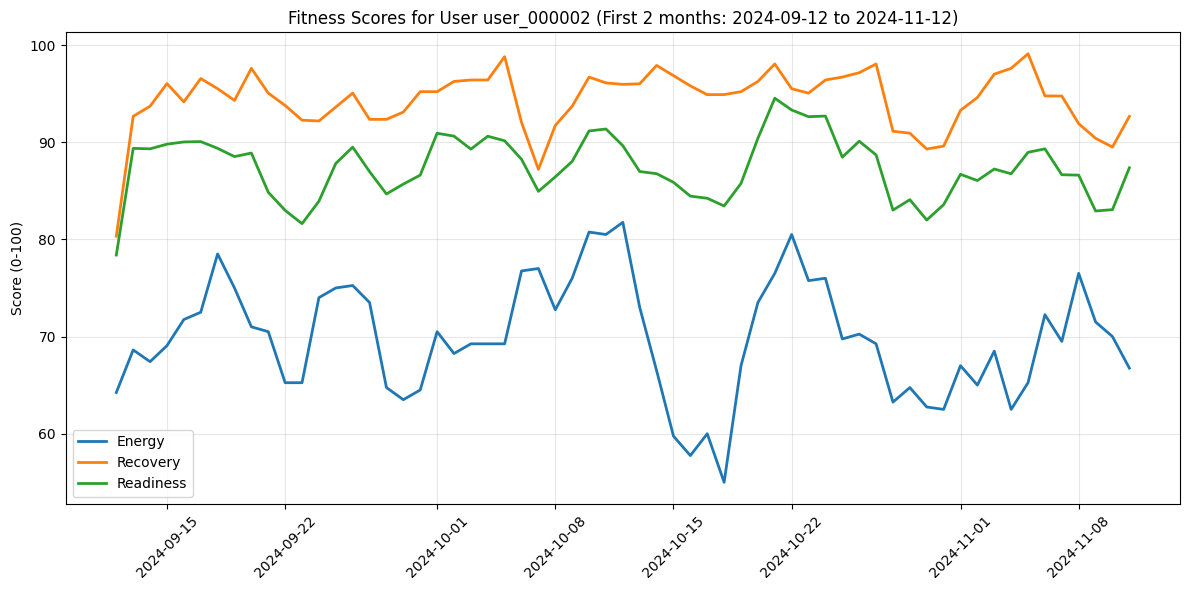

Plotting data from 2024-09-12 to 2024-11-12
Total data points: 61


In [155]:
plot_first_n_months(df_with_scores,n_months=2,user_id="user_000002")

In [142]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def safe_float(value, default=0.0):
    """Safely convert value to float"""
    try:
        if pd.isna(value):
            return default
        return float(value)
    except (ValueError, TypeError):
        return default

def prepare_training_data(df_with_scores):
    """
    Prepare training data using raw data from days T-1 and T-2 to predict scores at day T
    
    For each day T, use raw data from days T-1 and T-2 as input features
    to predict the calculated Energy/Recovery/Readiness scores at day T
    """
    
    # Sort by user and date
    df = df_with_scores.sort_values(['user_id', 'date']).copy()
    
    training_data = []
    
    for user_id, user_df in df.groupby('user_id'):
        user_df = user_df.reset_index(drop=True)
        
        # Need at least 3 days for each user (T-2, T-1, T)
        if len(user_df) < 3:
            continue
            
        # For each day starting from day 2 (index 2, which is day T)
        for i in range(2, len(user_df)):
            
            # Get the three days: T-2, T-1, T
            day_t = user_df.iloc[i]      # Current day (target)
            day_t_minus_1 = user_df.iloc[i-1]  # T-1
            day_t_minus_2 = user_df.iloc[i-2]  # T-2
            
            # Skip if target scores are missing
            if (pd.isna(day_t['Energy']) or 
                pd.isna(day_t['Recovery']) or 
                pd.isna(day_t['Readiness'])):
                continue
            
            # Create feature vector from raw data of T-2 and T-1
            features = {}
            
            # Day T-2 raw features
            features['t2_total_sleep'] = safe_float(day_t_minus_2.get('total_sleep', 7))
            features['t2_deep_sleep'] = safe_float(day_t_minus_2.get('deep_sleep', 1.5))
            features['t2_resting_heart_rate'] = safe_float(day_t_minus_2.get('resting_heart_rate', 70))
            features['t2_calories'] = safe_float(day_t_minus_2.get('calories', 2000))
            features['t2_calories_burned'] = safe_float(day_t_minus_2.get('calories_burned', 2000))
            features['t2_protein'] = safe_float(day_t_minus_2.get('protein', 100))
            features['t2_carbs'] = safe_float(day_t_minus_2.get('carbs', 200))
            features['t2_fat'] = safe_float(day_t_minus_2.get('fat', 70))
            
            # Map intensity to numeric for T-2
            intensity_map = {"Low": 0.3, "Moderate": 0.6, "High": 1.0}
            features['t2_intensity'] = intensity_map.get(day_t_minus_2.get('intensity', 'Low'), 0.3)
            
            # HRV for T-2 (if available)
            features['t2_hrv'] = safe_float(day_t_minus_2.get('value', 50))
            
            # Day T-1 raw features  
            features['t1_total_sleep'] = safe_float(day_t_minus_1.get('total_sleep', 7))
            features['t1_deep_sleep'] = safe_float(day_t_minus_1.get('deep_sleep', 1.5))
            features['t1_resting_heart_rate'] = safe_float(day_t_minus_1.get('resting_heart_rate', 70))
            features['t1_calories'] = safe_float(day_t_minus_1.get('calories', 2000))
            features['t1_calories_burned'] = safe_float(day_t_minus_1.get('calories_burned', 2000))
            features['t1_protein'] = safe_float(day_t_minus_1.get('protein', 100))
            features['t1_carbs'] = safe_float(day_t_minus_1.get('carbs', 200))
            features['t1_fat'] = safe_float(day_t_minus_1.get('fat', 70))
            
            # Map intensity to numeric for T-1
            features['t1_intensity'] = intensity_map.get(day_t_minus_1.get('intensity', 'Low'), 0.3)
            
            # HRV for T-1 (if available)
            features['t1_hrv'] = safe_float(day_t_minus_1.get('value', 50))
            
            # Derived features across the 2-day window (T-2, T-1)
            
            # Sleep patterns
            features['avg_sleep'] = (features['t2_total_sleep'] + features['t1_total_sleep']) / 2
            features['sleep_trend'] = features['t1_total_sleep'] - features['t2_total_sleep']
            features['sleep_consistency'] = abs(features['t1_total_sleep'] - features['t2_total_sleep'])
            
            # Deep sleep patterns
            t2_deep_ratio = features['t2_deep_sleep'] / max(features['t2_total_sleep'], 0.1)
            t1_deep_ratio = features['t1_deep_sleep'] / max(features['t1_total_sleep'], 0.1)
            features['avg_deep_sleep_ratio'] = (t2_deep_ratio + t1_deep_ratio) / 2
            features['deep_sleep_ratio_trend'] = t1_deep_ratio - t2_deep_ratio
            
            # Heart rate patterns
            features['avg_rhr'] = (features['t2_resting_heart_rate'] + features['t1_resting_heart_rate']) / 2
            features['rhr_trend'] = features['t1_resting_heart_rate'] - features['t2_resting_heart_rate']
            
            # HRV patterns
            features['avg_hrv'] = (features['t2_hrv'] + features['t1_hrv']) / 2
            features['hrv_trend'] = features['t1_hrv'] - features['t2_hrv']
            
            # Caloric balance patterns
            t2_net_cal = features['t2_calories'] - features['t2_calories_burned']
            t1_net_cal = features['t1_calories'] - features['t1_calories_burned']
            features['avg_net_calories'] = (t2_net_cal + t1_net_cal) / 2
            features['net_calories_trend'] = t1_net_cal - t2_net_cal
            
            # Activity patterns
            features['avg_intensity'] = (features['t2_intensity'] + features['t1_intensity']) / 2
            features['intensity_trend'] = features['t1_intensity'] - features['t2_intensity']
            
            # Nutrition patterns
            features['avg_protein'] = (features['t2_protein'] + features['t1_protein']) / 2
            features['protein_trend'] = features['t1_protein'] - features['t2_protein']
            
            features['avg_carbs'] = (features['t2_carbs'] + features['t1_carbs']) / 2
            features['carbs_trend'] = features['t1_carbs'] - features['t2_carbs']
            
            features['avg_fat'] = (features['t2_fat'] + features['t1_fat']) / 2
            features['fat_trend'] = features['t1_fat'] - features['t2_fat']
            
            # Macronutrient balance for each day
            for day_prefix, protein, carbs, fat in [('t2', features['t2_protein'], features['t2_carbs'], features['t2_fat']),
                                                   ('t1', features['t1_protein'], features['t1_carbs'], features['t1_fat'])]:
                total_macro_cals = 4 * protein + 4 * carbs + 9 * fat
                if total_macro_cals > 0:
                    features[f'{day_prefix}_carb_ratio'] = (4 * carbs) / total_macro_cals
                    features[f'{day_prefix}_protein_ratio'] = (4 * protein) / total_macro_cals
                    features[f'{day_prefix}_fat_ratio'] = (9 * fat) / total_macro_cals
                else:
                    features[f'{day_prefix}_carb_ratio'] = 0.5
                    features[f'{day_prefix}_protein_ratio'] = 0.25
                    features[f'{day_prefix}_fat_ratio'] = 0.25
            
            # Target scores from day T (7-day rolling window scores)
            features['target_energy'] = float(day_t['Energy'])
            features['target_recovery'] = float(day_t['Recovery'])
            features['target_readiness'] = float(day_t['Readiness'])
            
            # Metadata
            features['user_id'] = user_id
            features['date'] = day_t['date']
            
            training_data.append(features)
    
    return pd.DataFrame(training_data)

def train_xgboost_fitness_model(df_with_scores):
    """
    Train XGBoost models to predict existing fitness scores from 2 days of raw data
    """
    
    print("Preparing training data...")
    training_df = prepare_training_data(df_with_scores)
    
    print(f"Created {len(training_df)} training examples from {training_df['user_id'].nunique()} users")
    
    if len(training_df) == 0:
        print("ERROR: No training data created!")
        return None
    
    # Separate features and targets
    target_cols = ['target_energy', 'target_recovery', 'target_readiness']
    feature_cols = [col for col in training_df.columns if col not in target_cols + ['user_id', 'date']]
    
    print(f"Using {len(feature_cols)} features")
    
    X = training_df[feature_cols]
    y = training_df[target_cols]
    
    # Check target distributions
    print("\nTarget score statistics:")
    for col in target_cols:
        values = y[col]
        print(f"{col}: Mean={values.mean():.1f}, Std={values.std():.1f}, Min={values.min():.1f}, Max={values.max():.1f}")
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=training_df['user_id']
    )
    
    print(f"\nTraining set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    # Train separate XGBoost models for each target
    models = {}
    results = {}
    
    for target in target_cols:
        print(f"\nTraining XGBoost model for {target}...")
        
        # XGBoost parameters optimized for fitness data
        model = xgb.XGBRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            early_stopping_rounds=20,
            eval_metric='mae'
        )
        
        # Fit with validation set for early stopping
        model.fit(
            X_train, y_train[target],
            eval_set=[(X_test, y_test[target])],
            verbose=False
        )
        
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test[target], y_pred)
        r2 = r2_score(y_test[target], y_pred)
        
        print(f"{target}: MAE = {mae:.2f}, R² = {r2:.3f}")
        
        models[target] = model
        results[target] = {'MAE': mae, 'R2': r2, 'predictions': y_pred, 'actual': y_test[target]}
        
        # Feature importance from XGBoost
        feature_importance = dict(zip(feature_cols, model.feature_importances_))
        top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]
        print(f"Top features for {target}:")
        for feat, importance in top_features[:5]:
            print(f"  {feat}: {importance:.3f}")
    
    return {
        'models': models,
        'feature_cols': feature_cols,
        'results': results,
        'training_data': training_df
    }

def predict_scores_xgboost(model_dict, day_t_minus_2, day_t_minus_1):
    """
    Predict fitness scores using XGBoost models with raw data from 2 days
    """
    
    # Create feature vector (same logic as in prepare_training_data)
    features = {}
    
    intensity_map = {"Low": 0.3, "Moderate": 0.6, "High": 1.0}
    
    # Day T-2 raw features
    features['t2_total_sleep'] = safe_float(day_t_minus_2.get('total_sleep', 7))
    features['t2_deep_sleep'] = safe_float(day_t_minus_2.get('deep_sleep', 1.5))
    features['t2_resting_heart_rate'] = safe_float(day_t_minus_2.get('resting_heart_rate', 70))
    features['t2_calories'] = safe_float(day_t_minus_2.get('calories', 2000))
    features['t2_calories_burned'] = safe_float(day_t_minus_2.get('calories_burned', 2000))
    features['t2_protein'] = safe_float(day_t_minus_2.get('protein', 100))
    features['t2_carbs'] = safe_float(day_t_minus_2.get('carbs', 200))
    features['t2_fat'] = safe_float(day_t_minus_2.get('fat', 70))
    features['t2_intensity'] = intensity_map.get(day_t_minus_2.get('intensity', 'Low'), 0.3)
    features['t2_hrv'] = safe_float(day_t_minus_2.get('value', 50))
    
    # Day T-1 raw features  
    features['t1_total_sleep'] = safe_float(day_t_minus_1.get('total_sleep', 7))
    features['t1_deep_sleep'] = safe_float(day_t_minus_1.get('deep_sleep', 1.5))
    features['t1_resting_heart_rate'] = safe_float(day_t_minus_1.get('resting_heart_rate', 70))
    features['t1_calories'] = safe_float(day_t_minus_1.get('calories', 2000))
    features['t1_calories_burned'] = safe_float(day_t_minus_1.get('calories_burned', 2000))
    features['t1_protein'] = safe_float(day_t_minus_1.get('protein', 100))
    features['t1_carbs'] = safe_float(day_t_minus_1.get('carbs', 200))
    features['t1_fat'] = safe_float(day_t_minus_1.get('fat', 70))
    features['t1_intensity'] = intensity_map.get(day_t_minus_1.get('intensity', 'Low'), 0.3)
    features['t1_hrv'] = safe_float(day_t_minus_1.get('value', 50))
    
    # Derived features (same as training)
    features['avg_sleep'] = (features['t2_total_sleep'] + features['t1_total_sleep']) / 2
    features['sleep_trend'] = features['t1_total_sleep'] - features['t2_total_sleep']
    features['sleep_consistency'] = abs(features['t1_total_sleep'] - features['t2_total_sleep'])
    
    # Deep sleep patterns
    t2_deep_ratio = features['t2_deep_sleep'] / max(features['t2_total_sleep'], 0.1)
    t1_deep_ratio = features['t1_deep_sleep'] / max(features['t1_total_sleep'], 0.1)
    features['avg_deep_sleep_ratio'] = (t2_deep_ratio + t1_deep_ratio) / 2
    features['deep_sleep_ratio_trend'] = t1_deep_ratio - t2_deep_ratio
    
    # Heart rate patterns
    features['avg_rhr'] = (features['t2_resting_heart_rate'] + features['t1_resting_heart_rate']) / 2
    features['rhr_trend'] = features['t1_resting_heart_rate'] - features['t2_resting_heart_rate']
    
    # HRV patterns
    features['avg_hrv'] = (features['t2_hrv'] + features['t1_hrv']) / 2
    features['hrv_trend'] = features['t1_hrv'] - features['t2_hrv']
    
    # Caloric balance patterns
    t2_net_cal = features['t2_calories'] - features['t2_calories_burned']
    t1_net_cal = features['t1_calories'] - features['t1_calories_burned']
    features['avg_net_calories'] = (t2_net_cal + t1_net_cal) / 2
    features['net_calories_trend'] = t1_net_cal - t2_net_cal
    
    # Activity patterns
    features['avg_intensity'] = (features['t2_intensity'] + features['t1_intensity']) / 2
    features['intensity_trend'] = features['t1_intensity'] - features['t2_intensity']
    
    # Nutrition patterns
    features['avg_protein'] = (features['t2_protein'] + features['t1_protein']) / 2
    features['protein_trend'] = features['t1_protein'] - features['t2_protein']
    
    features['avg_carbs'] = (features['t2_carbs'] + features['t1_carbs']) / 2
    features['carbs_trend'] = features['t1_carbs'] - features['t2_carbs']
    
    features['avg_fat'] = (features['t2_fat'] + features['t1_fat']) / 2
    features['fat_trend'] = features['t1_fat'] - features['t2_fat']
    
    # Macronutrient ratios
    for day_prefix, protein, carbs, fat in [('t2', features['t2_protein'], features['t2_carbs'], features['t2_fat']),
                                           ('t1', features['t1_protein'], features['t1_carbs'], features['t1_fat'])]:
        total_macro_cals = 4 * protein + 4 * carbs + 9 * fat
        if total_macro_cals > 0:
            features[f'{day_prefix}_carb_ratio'] = (4 * carbs) / total_macro_cals
            features[f'{day_prefix}_protein_ratio'] = (4 * protein) / total_macro_cals
            features[f'{day_prefix}_fat_ratio'] = (9 * fat) / total_macro_cals
        else:
            features[f'{day_prefix}_carb_ratio'] = 0.5
            features[f'{day_prefix}_protein_ratio'] = 0.25
            features[f'{day_prefix}_fat_ratio'] = 0.25
    
    # Convert to DataFrame and align with training features
    feature_df = pd.DataFrame([features])
    feature_df = feature_df.reindex(columns=model_dict['feature_cols'], fill_value=0)
    
    # Make predictions
    predictions = {}
    for target in ['target_energy', 'target_recovery', 'target_readiness']:
        model = model_dict['models'][target]
        pred = model.predict(feature_df)[0]
        
        # Map back to clean names
        clean_name = target.replace('target_', '').title()
        predictions[clean_name] = pred
    
    return predictions

model_results = train_xgboost_fitness_model(df_with_scores)
predictions = predict_scores_xgboost(model_results, day_t_minus_2, day_t_minus_1)

Preparing training data...
Created 179432 training examples from 5000 users
Using 45 features

Target score statistics:
target_energy: Mean=69.1, Std=5.6, Min=50.7, Max=95.0
target_recovery: Mean=95.2, Std=1.7, Min=81.8, Max=100.0
target_readiness: Mean=87.2, Std=2.3, Min=75.6, Max=97.8

Training set: 143545 samples
Test set: 35887 samples

Training XGBoost model for target_energy...
target_energy: MAE = 2.52, R² = 0.579
Top features for target_energy:
  avg_intensity: 0.367
  t2_intensity: 0.293
  t1_intensity: 0.239
  t1_calories_burned: 0.023
  t2_calories_burned: 0.021

Training XGBoost model for target_recovery...
target_recovery: MAE = 0.83, R² = 0.278
Top features for target_recovery:
  avg_rhr: 0.367
  avg_deep_sleep_ratio: 0.101
  t1_resting_heart_rate: 0.019
  t1_deep_sleep: 0.018
  t2_deep_sleep: 0.016

Training XGBoost model for target_readiness...
target_readiness: MAE = 1.38, R² = 0.416
Top features for target_readiness:
  t2_intensity: 0.352
  avg_intensity: 0.242
  t1_i

In [148]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

def improved_prepare_sequential_data(df_with_scores, sequence_length=5):
    """
    Improved sequential data preparation with better feature engineering
    """
    # Sort by user and date
    df = df_with_scores.sort_values(['user_id', 'date']).copy()
    
    sequences = []
    targets = []
    
    # Define the feature columns to use (same as your XGBoost features)
    raw_feature_columns = [
        'total_sleep', 'deep_sleep', 'resting_heart_rate', 
        'calories', 'calories_burned', 'protein', 'carbs', 'fat', 'value'
    ]
    
    intensity_map = {"Low": 0.3, "Moderate": 0.6, "High": 1.0}
    
    for user_id, user_df in df.groupby('user_id'):
        user_df = user_df.reset_index(drop=True)
        
        # Need at least sequence_length + 1 days
        if len(user_df) < sequence_length + 1:
            continue
            
        # Create sequences
        for i in range(sequence_length, len(user_df)):
            # Extract sequence of days
            sequence_data = []
            for j in range(i - sequence_length, i):
                day_data = user_df.iloc[j]
                
                # Extract and process features (similar to your XGBoost approach)
                features = []
                
                # Basic features
                for col in raw_feature_columns:
                    if col == 'intensity':
                        value = intensity_map.get(day_data.get('intensity', 'Low'), 0.3)
                    else:
                        value = safe_float(day_data.get(col, 0))
                    features.append(value)
                
                # Add derived features similar to your XGBoost implementation
                # This helps the RNN by providing pre-engineered features
                if j > i - sequence_length:  # Not the first day in sequence
                    prev_day_data = user_df.iloc[j-1]
                    prev_total_sleep = safe_float(prev_day_data.get('total_sleep', 7))
                    curr_total_sleep = safe_float(day_data.get('total_sleep', 7))
                    
                    # Sleep trend
                    features.append(curr_total_sleep - prev_total_sleep)
                    
                    # HRV trend if available
                    prev_hrv = safe_float(prev_day_data.get('value', 50))
                    curr_hrv = safe_float(day_data.get('value', 50))
                    features.append(curr_hrv - prev_hrv)
                else:
                    features.extend([0, 0])  # Padding for first day
                
                sequence_data.append(features)
            
            # Get target (scores at day i)
            target_day = user_df.iloc[i]
            if (pd.isna(target_day['Energy']) or 
                pd.isna(target_day['Recovery']) or 
                pd.isna(target_day['Readiness'])):
                continue
                
            target = [
                float(target_day['Energy']),
                float(target_day['Recovery']),
                float(target_day['Readiness'])
            ]
            
            sequences.append(sequence_data)
            targets.append(target)
    
    return np.array(sequences), np.array(targets)

def build_improved_rnn_model(input_shape, learning_rate=0.2):
    """
    Build a more effective RNN model
    """
    model = Sequential([
        # First LSTM layer
        LSTM(128, return_sequences=True, input_shape=input_shape,
             kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second LSTM layer
        LSTM(64, return_sequences=True,
             kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Third LSTM layer
        LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Dense layers
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        # Output layer for Energy, Recovery, Readiness
        Dense(3)
    ])
    
    optimizer = Adam(learning_rate=learning_rate, clipvalue=0.5)
    model.compile(
        optimizer=optimizer,
        loss='mse',  # Using MSE instead of MAE for better gradient behavior
        metrics=['mae']
    )
    
    return model

def train_improved_rnn(df_with_scores):
    """
    Improved RNN training with better practices
    """
    print("Preparing improved sequential data...")
    X, y = improved_prepare_sequential_data(df_with_scores, sequence_length=5)
    
    print(f"Created {len(X)} sequences with shape {X.shape}")
    print(f"Target shape: {y.shape}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale the features using RobustScaler (better for outliers)
    scalers = []
    for i in range(X.shape[2]):
        scaler = RobustScaler()
        X_train_reshaped = X_train[:, :, i].reshape(-1, 1)
        X_test_reshaped = X_test[:, :, i].reshape(-1, 1)
        
        scaler.fit(X_train_reshaped)
        X_train[:, :, i] = scaler.transform(X_train_reshaped).reshape(X_train.shape[0], X_train.shape[1])
        X_test[:, :, i] = scaler.transform(X_test_reshaped).reshape(X_test.shape[0], X_test.shape[1])
        
        scalers.append(scaler)
    
    # Build and train the model
    model = build_improved_rnn_model((X.shape[1], X.shape[2]))
    
    print(model.summary())
    
    # Callbacks
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True, monitor='val_mae'),
        ReduceLROnPlateau(factor=0.5, patience=10, min_lr=1e-6)
    ]
    
    # Train the model with a smaller batch size
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=5,
        batch_size=16,  # Smaller batch size for better generalization
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Calculate metrics for each target
    results = {}
    target_names = ['Energy', 'Recovery', 'Readiness']
    
    for i, target in enumerate(target_names):
        mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
        r2 = r2_score(y_test[:, i], y_pred[:, i])
        
        results[target] = {
            'MAE': mae,
            'R2': r2,
            'predictions': y_pred[:, i],
            'actual': y_test[:, i]
        }
        
        print(f"{target}: MAE = {mae:.3f}, R² = {r2:.4f}")
    
    return {
        'model': model,
        'results': results,
        'history': history,
        'scalers': scalers
    }

# Alternative approach: Use a simpler model if the complex one doesn't work
def build_simple_rnn_model(input_shape, learning_rate=0.001):
    """
    Build a simpler RNN model that might work better with your data
    """
    model = Sequential([
        LSTM(32, input_shape=input_shape),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(3)  # Output layer for Energy, Recovery, Readiness
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mae',
        metrics=['mae']
    )
    
    return model

# Try the improved RNN
print("Training improved RNN model...")
improved_rnn_results = train_improved_rnn(df_with_scores)

Training improved RNN model...
Preparing improved sequential data...
Created 164432 sequences with shape (164432, 5, 11)
Target shape: (164432, 3)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 5, 128)         │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 5, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,075 (543.26 KB)

 Trainable params: 138,435 (540.76 KB)

 Non-trainable params: 640 (2.50 KB)

None
Epoch 1/5
8222/8222 ━━━━━━━━━━━━━━━━━━━━ 119s 13ms/step - loss: 125.4822 - mae: 6.2395 - val_loss: 19.8639 - val_mae: 2.8416 - learning_rate: 0.2000
Epoch 2/5
8222/8222 ━━━━━━━━━━━━━━━━━━━━ 105s 13ms/step - loss: 18.8531 - mae: 2.6624 - val_loss: 13.4469 - val_mae: 2.5748 - learning_rate: 0.2000
Epoch 3/5
8222/8222 ━━━━━━━━━━━━━━━━━━━━ 106s 13ms/step - loss: 14.3762 - mae: 2.6694 - val_loss: 15.5408 - val_mae: 2.8813 - learning_rate: 0.2000
Epoch 4/5
8222/8222 ━━━━━━━━━━━━━━━━━━━━ 107s 13ms/step - loss: 14.2307 - mae: 2.6609 - val_loss: 13.3863 - val_mae: 2.5340 - learning_rate: 0.2000
Epoch 5/5
8222/8222 ━━━━━━━━━━━━━━━━━━━━ 107s 13ms/step - loss: 14.3524 - mae: 2.6687 - val_loss: 16.1002 - val_mae: 2.9668 - learning_rate: 0.2000
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Energy: MAE = 4.680, R² = -0.0019
Recovery: MAE = 1.078, R² = -0.0192
Readiness: MAE = 1.844, R² = -0.0165


In [159]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb

def train_simple_models(training_df):
    """
    Train simple Random Forest and XGBoost models
    """
    # Separate features and targets
    target_cols = ['target_energy', 'target_recovery', 'target_readiness']
    feature_cols = [col for col in training_df.columns if col not in target_cols + ['user_id', 'date']]
    
    X = training_df[feature_cols]
    y = training_df[target_cols]
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=training_df['user_id']
    )
    
    # Initialize results dictionaries
    rf_results = {}
    xgb_results = {}
    
    # Train models for each target
    for target in target_cols:
        print(f"\nTraining models for {target.replace('target_', '').title()}...")
        print("-" * 50)
        
        # Train Random Forest
        rf_model = RandomForestRegressor(
            n_estimators=300,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(X_train, y_train[target])
        rf_pred = rf_model.predict(X_test)
        
        rf_mae = mean_absolute_error(y_test[target], rf_pred)
        rf_r2 = r2_score(y_test[target], rf_pred)
        
        rf_results[target] = {'MAE': rf_mae, 'R2': rf_r2}
        print(f"Random Forest: MAE = {rf_mae:.3f}, R² = {rf_r2:.4f}")
        
        # Train XGBoost
        xgb_model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        )
        xgb_model.fit(X_train, y_train[target])
        xgb_pred = xgb_model.predict(X_test)
        
        xgb_mae = mean_absolute_error(y_test[target], xgb_pred)
        xgb_r2 = r2_score(y_test[target], xgb_pred)
        
        xgb_results[target] = {'MAE': xgb_mae, 'R2': xgb_r2}
        print(f"XGBoost:      MAE = {xgb_mae:.3f}, R² = {xgb_r2:.4f}")
    
    return {
        'rf_results': rf_results,
        'xgb_results': xgb_results,
        'feature_cols': feature_cols
    }

# Main execution
print("Preparing training data...")
training_df = prepare_training_data(df_with_scores)
print(f"Created {len(training_df)} training examples")

print("\n" + "="*60)
print("TRAINING SIMPLE MODELS")
print("="*60)

results = train_simple_models(training_df)

# Print summary
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"{'Target':<12} {'Model':<15} {'MAE':<8} {'R²':<8}")
print("-" * 60)

target_names = {
    'target_energy': 'Energy',
    'target_recovery': 'Recovery', 
    'target_readiness': 'Readiness'
}

for target in ['target_energy', 'target_recovery', 'target_readiness']:
    rf_mae = results['rf_results'][target]['MAE']
    rf_r2 = results['rf_results'][target]['R2']
    xgb_mae = results['xgb_results'][target]['MAE']
    xgb_r2 = results['xgb_results'][target]['R2']
    
    print(f"{target_names[target]:<12} {'Random Forest':<15} {rf_mae:.3f}   {rf_r2:.4f}")
    print(f"{target_names[target]:<12} {'XGBoost':<15} {xgb_mae:.3f}   {xgb_r2:.4f}")
    print("-" * 60)

# Determine best model for each target
print("\n" + "="*60)
print("BEST MODEL FOR EACH TARGET")
print("="*60)

for target in ['target_energy', 'target_recovery', 'target_readiness']:
    rf_r2 = results['rf_results'][target]['R2']
    xgb_r2 = results['xgb_results'][target]['R2']
    
    if rf_r2 > xgb_r2:
        best_model = "Random Forest"
        best_r2 = rf_r2
    else:
        best_model = "XGBoost"
        best_r2 = xgb_r2
        
    print(f"{target_names[target]:<12}: {best_model} (R² = {best_r2:.4f})")

Preparing training data...
Created 179432 training examples

TRAINING SIMPLE MODELS

Training models for Energy...
--------------------------------------------------
Random Forest: MAE = 2.666, R² = 0.6648
XGBoost:      MAE = 2.665, R² = 0.6661

Training models for Recovery...
--------------------------------------------------


KeyboardInterrupt: 

In [161]:
import joblib
import json
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import os

def safe_float(value, default=0.0):
    """Safely convert value to float"""
    try:
        if pd.isna(value):
            return default
        return float(value)
    except (ValueError, TypeError):
        return default

def prepare_input_features_complete(input_data):
    """
    Prepare input features with ALL derived features used in training
    """
    day_t_minus_2 = input_data['day_t_minus_2']
    day_t_minus_1 = input_data['day_t_minus_1']
    
    features = {}
    intensity_map = {"Low": 0.3, "Moderate": 0.6, "High": 1.0}
    
    # Day T-2 raw features
    features['t2_total_sleep'] = safe_float(day_t_minus_2.get('total_sleep', 7))
    features['t2_deep_sleep'] = safe_float(day_t_minus_2.get('deep_sleep', 1.5))
    features['t2_resting_heart_rate'] = safe_float(day_t_minus_2.get('resting_heart_rate', 70))
    features['t2_calories'] = safe_float(day_t_minus_2.get('calories', 2000))
    features['t2_calories_burned'] = safe_float(day_t_minus_2.get('calories_burned', 2000))
    features['t2_protein'] = safe_float(day_t_minus_2.get('protein', 100))
    features['t2_carbs'] = safe_float(day_t_minus_2.get('carbs', 200))
    features['t2_fat'] = safe_float(day_t_minus_2.get('fat', 70))
    features['t2_intensity'] = intensity_map.get(day_t_minus_2.get('intensity', 'Low'), 0.3)
    features['t2_hrv'] = safe_float(day_t_minus_2.get('value', 50))
    
    # Day T-1 raw features  
    features['t1_total_sleep'] = safe_float(day_t_minus_1.get('total_sleep', 7))
    features['t1_deep_sleep'] = safe_float(day_t_minus_1.get('deep_sleep', 1.5))
    features['t1_resting_heart_rate'] = safe_float(day_t_minus_1.get('resting_heart_rate', 70))
    features['t1_calories'] = safe_float(day_t_minus_1.get('calories', 2000))
    features['t1_calories_burned'] = safe_float(day_t_minus_1.get('calories_burned', 2000))
    features['t1_protein'] = safe_float(day_t_minus_1.get('protein', 100))
    features['t1_carbs'] = safe_float(day_t_minus_1.get('carbs', 200))
    features['t1_fat'] = safe_float(day_t_minus_1.get('fat', 70))
    features['t1_intensity'] = intensity_map.get(day_t_minus_1.get('intensity', 'Low'), 0.3)
    features['t1_hrv'] = safe_float(day_t_minus_1.get('value', 50))
    
    # Derived features across the 2-day window (T-2, T-1)
    features['avg_sleep'] = (features['t2_total_sleep'] + features['t1_total_sleep']) / 2
    features['sleep_trend'] = features['t1_total_sleep'] - features['t2_total_sleep']
    features['sleep_consistency'] = abs(features['t1_total_sleep'] - features['t2_total_sleep'])
    
    # Deep sleep patterns
    t2_deep_ratio = features['t2_deep_sleep'] / max(features['t2_total_sleep'], 0.1)
    t1_deep_ratio = features['t1_deep_sleep'] / max(features['t1_total_sleep'], 0.1)
    features['avg_deep_sleep_ratio'] = (t2_deep_ratio + t1_deep_ratio) / 2
    features['deep_sleep_ratio_trend'] = t1_deep_ratio - t2_deep_ratio
    
    # Heart rate patterns
    features['avg_rhr'] = (features['t2_resting_heart_rate'] + features['t1_resting_heart_rate']) / 2
    features['rhr_trend'] = features['t1_resting_heart_rate'] - features['t2_resting_heart_rate']
    
    # HRV patterns
    features['avg_hrv'] = (features['t2_hrv'] + features['t1_hrv']) / 2
    features['hrv_trend'] = features['t1_hrv'] - features['t2_hrv']
    
    # Caloric balance patterns
    t2_net_cal = features['t2_calories'] - features['t2_calories_burned']
    t1_net_cal = features['t1_calories'] - features['t1_calories_burned']
    features['avg_net_calories'] = (t2_net_cal + t1_net_cal) / 2
    features['net_calories_trend'] = t1_net_cal - t2_net_cal
    
    # Activity patterns
    features['avg_intensity'] = (features['t2_intensity'] + features['t1_intensity']) / 2
    features['intensity_trend'] = features['t1_intensity'] - features['t2_intensity']
    
    # Nutrition patterns
    features['avg_protein'] = (features['t2_protein'] + features['t1_protein']) / 2
    features['protein_trend'] = features['t1_protein'] - features['t2_protein']
    
    features['avg_carbs'] = (features['t2_carbs'] + features['t1_carbs']) / 2
    features['carbs_trend'] = features['t1_carbs'] - features['t2_carbs']
    
    features['avg_fat'] = (features['t2_fat'] + features['t1_fat']) / 2
    features['fat_trend'] = features['t1_fat'] - features['t2_fat']
    
    # Macronutrient ratios for each day
    for day_prefix, protein, carbs, fat in [('t2', features['t2_protein'], features['t2_carbs'], features['t2_fat']),
                                           ('t1', features['t1_protein'], features['t1_carbs'], features['t1_fat'])]:
        total_macro_cals = 4 * protein + 4 * carbs + 9 * fat
        if total_macro_cals > 0:
            features[f'{day_prefix}_carb_ratio'] = (4 * carbs) / total_macro_cals
            features[f'{day_prefix}_protein_ratio'] = (4 * protein) / total_macro_cals
            features[f'{day_prefix}_fat_ratio'] = (9 * fat) / total_macro_cals
        else:
            features[f'{day_prefix}_carb_ratio'] = 0.5
            features[f'{day_prefix}_protein_ratio'] = 0.25
            features[f'{day_prefix}_fat_ratio'] = 0.25
    
    return features

def save_xgboost_models(results, training_df, model_dir="xgboost_models"):
    """
    Save XGBoost models to disk
    """
    # Create directory if it doesn't exist
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    # Save feature columns
    joblib.dump(results['feature_cols'], os.path.join(model_dir, 'feature_columns.pkl'))
    
    # Save XGBoost models for each target
    target_cols = ['target_energy', 'target_recovery', 'target_readiness']
    
    for target in target_cols:
        # Train and save XGBoost model
        xgb_model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        )
        
        # Get the training data
        X = training_df[results['feature_cols']]
        y = training_df[target]
        
        xgb_model.fit(X, y)
        joblib.dump(xgb_model, os.path.join(model_dir, f'xgboost_{target}.pkl'))
        print(f"Saved XGBoost model for {target.replace('target_', '').title()}")
    
    print(f"\nAll XGBoost models saved to {model_dir}/ directory")

def create_input_json_template(filename="input_template.json"):
    """
    Create a JSON template showing the expected input format
    """
    template = {
        "day_t_minus_2": {
            "total_sleep": 7.5,
            "deep_sleep": 1.8,
            "resting_heart_rate": 58,
            "calories": 2200,
            "calories_burned": 2400,
            "protein": 110,
            "carbs": 250,
            "fat": 75,
            "intensity": "Moderate",
            "value": 65
        },
        "day_t_minus_1": {
            "total_sleep": 8.2,
            "deep_sleep": 2.1,
            "resting_heart_rate": 56,
            "calories": 2300,
            "calories_burned": 2100,
            "protein": 120,
            "carbs": 270,
            "fat": 80,
            "intensity": "Low",
            "value": 68
        }
    }
    
    # Save to file
    with open(filename, 'w') as f:
        json.dump(template, f, indent=2)
    
    print(f"Input template saved to {filename}")
    return template

def predict_with_xgboost(input_data, model_dir="xgboost_models"):
    """
    Make predictions using the saved XGBoost models with complete feature preparation
    """
    # Load feature columns
    feature_cols = joblib.load(os.path.join(model_dir, 'feature_columns.pkl'))
    
    # Prepare input features with ALL derived features
    features = prepare_input_features_complete(input_data)
    
    # Convert to DataFrame with correct feature order
    feature_df = pd.DataFrame([features])
    feature_df = feature_df[feature_cols]  # Ensure correct feature order
    
    predictions = {}
    target_names = {
        'target_energy': 'Energy',
        'target_recovery': 'Recovery',
        'target_readiness': 'Readiness'
    }
    
    # Make predictions for each target
    for target in ['target_energy', 'target_recovery', 'target_readiness']:
        model_path = os.path.join(model_dir, f'xgboost_{target}.pkl')
        if os.path.exists(model_path):
            model = joblib.load(model_path)
            pred = model.predict(feature_df)[0]
            clean_name = target_names[target]
            predictions[clean_name] = float(pred)
        else:
            print(f"Model not found: {model_path}")
    
    return predictions

# Main execution
print("Preparing training data...")
training_df = prepare_training_data(df_with_scores)
print(f"Created {len(training_df)} training examples")

print("\n" + "="*60)
print("TRAINING XGBOOST MODELS")
print("="*60)

# Train models and get results
results = train_simple_models(training_df)

print("\n" + "="*60)
print("SAVING XGBOOST MODELS")
print("="*60)

# Save XGBoost models with complete feature set
save_xgboost_models(results, training_df)

print("\n" + "="*60)
print("CREATING INPUT TEMPLATE")
print("="*60)

# Create input JSON template
input_template = create_input_json_template()

print("\n" + "="*60)
print("EXAMPLE USAGE WITH COMPLETE FEATURES")
print("="*60)

# Example of how to use the saved models
sample_input = {
    "day_t_minus_2": {
        "total_sleep": 7.5,
        "deep_sleep": 1.8,
        "resting_heart_rate": 58,
        "calories": 2200,
        "calories_burned": 2400,
        "protein": 110,
        "carbs": 250,
        "fat": 75,
        "intensity": "Moderate",
        "value": 65
    },
    "day_t_minus_1": {
        "total_sleep": 8.2,
        "deep_sleep": 2.1,
        "resting_heart_rate": 56,
        "calories": 2300,
        "calories_burned": 2100,
        "protein": 120,
        "carbs": 270,
        "fat": 80,
        "intensity": "Low",
        "value": 68
    }
}

# Make prediction with complete feature preparation
try:
    predictions = predict_with_xgboost(sample_input)
    print("Predicted Scores:")
    for metric, score in predictions.items():
        print(f"{metric}: {score:.1f}")
except Exception as e:
    print(f"Prediction error: {e}")

print("\n" + "="*60)
print("FEATURE IMPORTANCE CHECK")
print("="*60)

# Check what features we're using
feature_cols = joblib.load(os.path.join("xgboost_models", 'feature_columns.pkl'))
print(f"Number of features: {len(feature_cols)}")
print("First 10 features:")
for i, feature in enumerate(feature_cols[:10]):
    print(f"  {i+1}. {feature}")

print("\n" + "="*60)
print("HOW TO USE LATER")
print("="*60)
print("1. Models are saved in 'xgboost_models/' directory")
print("2. Input format template is saved in 'input_template.json'")
print("3. Use predict_with_xgboost() function with your input data")
print("4. Required files for deployment:")
print("   - xgboost_models/feature_columns.pkl")
print("   - xgboost_models/xgboost_target_energy.pkl")
print("   - xgboost_models/xgboost_target_recovery.pkl")
print("   - xgboost_models/xgboost_target_readiness.pkl")

Preparing training data...
Created 179432 training examples

TRAINING XGBOOST MODELS

Training models for Energy...
--------------------------------------------------
Random Forest: MAE = 2.666, R² = 0.6648
XGBoost:      MAE = 2.665, R² = 0.6661

Training models for Recovery...
--------------------------------------------------
Random Forest: MAE = 0.992, R² = 0.4647
XGBoost:      MAE = 0.994, R² = 0.4647

Training models for Readiness...
--------------------------------------------------
Random Forest: MAE = 1.523, R² = 0.5346
XGBoost:      MAE = 1.512, R² = 0.5431

SAVING XGBOOST MODELS
Saved XGBoost model for Energy
Saved XGBoost model for Recovery
Saved XGBoost model for Readiness

All XGBoost models saved to xgboost_models/ directory

CREATING INPUT TEMPLATE
Input template saved to input_template.json

EXAMPLE USAGE WITH COMPLETE FEATURES
Predicted Scores:
Energy: 66.9
Recovery: 94.0
Readiness: 87.8

FEATURE IMPORTANCE CHECK
Number of features: 45
First 10 features:
  1. t2_total_

In [162]:
import shutil

# Path to your folder
folder_path = "/kaggle/working/xgboost_models"
zip_filename = "xgboost_models"

# Create a zip archive of the folder
shutil.make_archive(zip_filename, 'zip', folder_path)

print("Zipped folder saved as:", f"{zip_filename}.zip")

Zipped folder saved as: xgboost_models.zip


In [164]:
import os
import joblib
import pandas as pd
import json

# -----------------------------
# Helper function
# -----------------------------
def safe_float(value, default=0.0):
    try:
        return float(value)
    except (TypeError, ValueError):
        return default

# -----------------------------
# Feature preparation
# -----------------------------
def prepare_input_features_complete(input_data):
    """
    Prepare input features with ALL derived features used in training
    """
    day_t_minus_2 = input_data['day_t_minus_2']
    day_t_minus_1 = input_data['day_t_minus_1']
    
    features = {}
    intensity_map = {"Low": 0.3, "Moderate": 0.6, "High": 1.0}
    
    # Day T-2 raw features
    features['t2_total_sleep'] = safe_float(day_t_minus_2.get('total_sleep', 7))
    features['t2_deep_sleep'] = safe_float(day_t_minus_2.get('deep_sleep', 1.5))
    features['t2_resting_heart_rate'] = safe_float(day_t_minus_2.get('resting_heart_rate', 70))
    features['t2_calories'] = safe_float(day_t_minus_2.get('calories', 2000))
    features['t2_calories_burned'] = safe_float(day_t_minus_2.get('calories_burned', 2000))
    features['t2_protein'] = safe_float(day_t_minus_2.get('protein', 100))
    features['t2_carbs'] = safe_float(day_t_minus_2.get('carbs', 200))
    features['t2_fat'] = safe_float(day_t_minus_2.get('fat', 70))
    features['t2_intensity'] = intensity_map.get(day_t_minus_2.get('intensity', 'Low'), 0.3)
    features['t2_hrv'] = safe_float(day_t_minus_2.get('value', 50))
    
    # Day T-1 raw features  
    features['t1_total_sleep'] = safe_float(day_t_minus_1.get('total_sleep', 7))
    features['t1_deep_sleep'] = safe_float(day_t_minus_1.get('deep_sleep', 1.5))
    features['t1_resting_heart_rate'] = safe_float(day_t_minus_1.get('resting_heart_rate', 70))
    features['t1_calories'] = safe_float(day_t_minus_1.get('calories', 2000))
    features['t1_calories_burned'] = safe_float(day_t_minus_1.get('calories_burned', 2000))
    features['t1_protein'] = safe_float(day_t_minus_1.get('protein', 100))
    features['t1_carbs'] = safe_float(day_t_minus_1.get('carbs', 200))
    features['t1_fat'] = safe_float(day_t_minus_1.get('fat', 70))
    features['t1_intensity'] = intensity_map.get(day_t_minus_1.get('intensity', 'Low'), 0.3)
    features['t1_hrv'] = safe_float(day_t_minus_1.get('value', 50))
    
    # Derived features across the 2-day window
    features['avg_sleep'] = (features['t2_total_sleep'] + features['t1_total_sleep']) / 2
    features['sleep_trend'] = features['t1_total_sleep'] - features['t2_total_sleep']
    features['sleep_consistency'] = abs(features['t1_total_sleep'] - features['t2_total_sleep'])
    
    # Deep sleep ratios
    t2_deep_ratio = features['t2_deep_sleep'] / max(features['t2_total_sleep'], 0.1)
    t1_deep_ratio = features['t1_deep_sleep'] / max(features['t1_total_sleep'], 0.1)
    features['avg_deep_sleep_ratio'] = (t2_deep_ratio + t1_deep_ratio) / 2
    features['deep_sleep_ratio_trend'] = t1_deep_ratio - t2_deep_ratio
    
    # Heart rate & HRV
    features['avg_rhr'] = (features['t2_resting_heart_rate'] + features['t1_resting_heart_rate']) / 2
    features['rhr_trend'] = features['t1_resting_heart_rate'] - features['t2_resting_heart_rate']
    features['avg_hrv'] = (features['t2_hrv'] + features['t1_hrv']) / 2
    features['hrv_trend'] = features['t1_hrv'] - features['t2_hrv']
    
    # Caloric balance
    t2_net_cal = features['t2_calories'] - features['t2_calories_burned']
    t1_net_cal = features['t1_calories'] - features['t1_calories_burned']
    features['avg_net_calories'] = (t2_net_cal + t1_net_cal) / 2
    features['net_calories_trend'] = t1_net_cal - t2_net_cal
    
    # Activity intensity
    features['avg_intensity'] = (features['t2_intensity'] + features['t1_intensity']) / 2
    features['intensity_trend'] = features['t1_intensity'] - features['t2_intensity']
    
    # Nutrition patterns
    features['avg_protein'] = (features['t2_protein'] + features['t1_protein']) / 2
    features['protein_trend'] = features['t1_protein'] - features['t2_protein']
    features['avg_carbs'] = (features['t2_carbs'] + features['t1_carbs']) / 2
    features['carbs_trend'] = features['t1_carbs'] - features['t2_carbs']
    features['avg_fat'] = (features['t2_fat'] + features['t1_fat']) / 2
    features['fat_trend'] = features['t1_fat'] - features['t2_fat']
    
    # Macronutrient ratios
    for day_prefix, protein, carbs, fat in [('t2', features['t2_protein'], features['t2_carbs'], features['t2_fat']),
                                           ('t1', features['t1_protein'], features['t1_carbs'], features['t1_fat'])]:
        total_macro_cals = 4 * protein + 4 * carbs + 9 * fat
        if total_macro_cals > 0:
            features[f'{day_prefix}_carb_ratio'] = (4 * carbs) / total_macro_cals
            features[f'{day_prefix}_protein_ratio'] = (4 * protein) / total_macro_cals
            features[f'{day_prefix}_fat_ratio'] = (9 * fat) / total_macro_cals
        else:
            features[f'{day_prefix}_carb_ratio'] = 0.5
            features[f'{day_prefix}_protein_ratio'] = 0.25
            features[f'{day_prefix}_fat_ratio'] = 0.25
    
    return features

# -----------------------------
# Prediction function
# -----------------------------
def predict_with_xgboost(input_data, model_dir="xgboost_models"):
    """
    Make predictions for Energy, Recovery, Readiness
    """
    # Load feature columns
    feature_cols_path = os.path.join(model_dir, 'feature_columns.pkl')
    feature_cols = joblib.load(feature_cols_path)
    
    # Prepare features
    features = prepare_input_features_complete(input_data)
    feature_df = pd.DataFrame([features])
    
    # Fill missing columns with 0
    for col in feature_cols:
        if col not in feature_df.columns:
            feature_df[col] = 0
            
    feature_df = feature_df[feature_cols]  # Ensure correct order
    
    predictions = {}
    target_names = {
        'target_energy': 'Energy',
        'target_recovery': 'Recovery',
        'target_readiness': 'Readiness'
    }
    
    for target in ['target_energy', 'target_recovery', 'target_readiness']:
        model_path = os.path.join(model_dir, f'xgboost_{target}.pkl')
        if os.path.exists(model_path):
            model = joblib.load(model_path)
            pred = model.predict(feature_df)[0]
            predictions[target_names[target]] = float(pred)
        else:
            print(f"⚠️ Model not found: {model_path}")
    
    return predictions

# -----------------------------
# Example usage
# -----------------------------
try:
    with open("input_template.json", "r") as f:
        input_template = json.load(f)
    
    preds = predict_with_xgboost(input_template)
    print("✅ Predictions:", preds)
except:
    print('Error')

✅ Predictions: {'Energy': 66.86919403076172, 'Recovery': 93.95526885986328, 'Readiness': 87.82832336425781}
